In [1]:
import pandas as pd
import numpy as np
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
import folium
from datetime import datetime
%matplotlib inline

In [2]:
main_df = pd.DataFrame()

In [3]:
available_paths = ["twitter_august.pkl",  "twitter_july.pkl",  "twitter_october.pkl",  "twitter_september.pkl"]
available_paths_complete = ["datasets/filtered_dfs/{}".format(path) for path in available_paths]

In [4]:
for path in available_paths_complete:
    with open(path, "rb") as handle:
        new_df = pickle.load(handle)
        main_df = main_df.append(new_df)

In [5]:
len(main_df)

3726373

In [6]:
main_df.isnull().sum()

author_gender          94
geo_country             0
geo_state               0
lang                    0
main                    0
published               0
sentiment               0
source_location    143426
sentiment_int           0
dtype: int64

In [7]:
print(len(main_df[main_df["sentiment"] == "POSITIVE"]))
print(len(main_df[main_df["sentiment"] == "NEGATIVE"]))
print(len(main_df[main_df["sentiment"] == "NEUTRAL"]))

608956
281200
2836217


In [8]:
positive_corpus = " ".join(main_df[main_df["sentiment"] == "POSITIVE"]["main"])
negative_corpus = " ".join(main_df[main_df["sentiment"] == "NEGATIVE"]["main"])

(-0.5, 399.5, 199.5, -0.5)

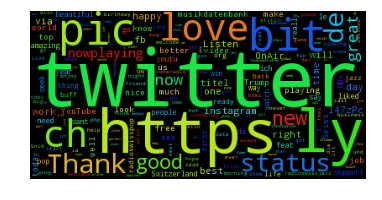

In [9]:
wordcloud = WordCloud().generate(positive_corpus)
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

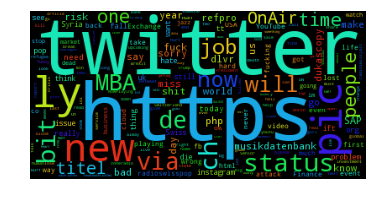

In [10]:
wordcloud = WordCloud().generate(negative_corpus)
plt.imshow(wordcloud)
plt.axis("off")

In [11]:
main_df.groupby("geo_state").count()["main"]

geo_state
                                       47
Aargau                             146747
Abu Dhabi                              29
Abuja Federal Capital Territory         8
Adamawa                                 5
Akershus                                6
Alba                                    1
Alberta                                15
Amazonas                                1
Amhara                                  4
Amman                                  17
Andorra la Vella                        6
Antalya                                 3
Antioquia                               2
Appenzell Ausserrhoden               2939
Appenzell Innerrhoden                2920
Ar Riyāḑ                                1
Attica                                  5
Auckland                               14
Aveiro                                 10
Baden-Württemberg                    7246
Bahia                                  22
Baladīyat ad Dawḩah                    12
Baladīyat ar Rayyān     

In [12]:
# Removing geo_state with few tweets, because they are not swiss cantons. ~0.4% of the data
main_df = main_df.groupby("geo_state").filter(lambda x: x.count()["main"] > 1000)

In [13]:
main_df.groupby("geo_state").count()["main"]

geo_state
Aargau                    146747
Appenzell Ausserrhoden      2939
Appenzell Innerrhoden       2920
Baden-Württemberg           7246
Basel-City                220006
Basel-Landschaft           21665
Bern                      284840
Fribourg                   95226
Geneva                    908988
Glarus                      5718
Grisons                    21883
Haryana                     1231
Jura                       46697
Lucerne                    85608
Neuchâtel                  44454
Nidwalden                  52154
North Rhine-Westphalia      1027
Obwalden                    3821
Saint Gallen               48249
Schaffhausen               30680
Schwyz                     13787
Solothurn                  21793
Thurgau                    17464
Ticino                    308531
Uri                        25122
Valais                    104359
Vaud                      291065
Zug                        41941
Zurich                    858656
Name: main, dtype: int64

In [14]:
fake_cantons = ["Baden-Württemberg", "Haryana", "North Rhine-Westphalia"]

In [15]:
# Removing fake_cantons
main_df = main_df[~(main_df["geo_state"].isin(fake_cantons))]

In [16]:
def merge_clean_df(pickle_list):
    '''Import DataFrames from different pickle files, merge them and clean the data'''
    # == MERGE ==
    main_df = pd.DataFrame()
    paths = ["datasets/filtered_dfs/{}".format(path) for path in pickle_list]
    
    for path in available_paths_complete:
        with open(path, "rb") as handle:
            new_df = pickle.load(handle)
            main_df = main_df.append(new_df)

    # == CLEAN ==
    # Remove geo_state with few tweets, because they are not swiss cantons. ~0.4% of the data
    main_df = main_df.groupby("geo_state").filter(lambda x: x.count()["main"] > 1000)
    fake_cantons = ["Baden-Württemberg", "Haryana", "North Rhine-Westphalia"]
    
    # Removing fake_cantons
    main_df = main_df[~(main_df["geo_state"].isin(fake_cantons))]
    
    return main_df

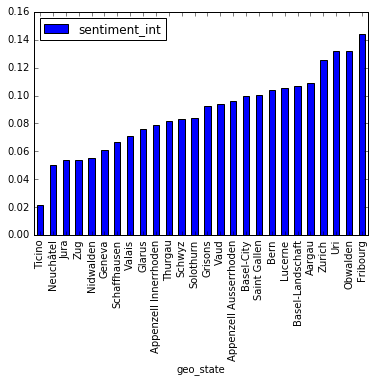

In [17]:
main_df.groupby("geo_state").mean().sort_values(by="sentiment_int").plot(kind="bar")

In [18]:
sbb_words = ["cff", "sbb", "ffs"]

In [19]:
def contains_str(string):
    return main_df["main"].str.contains(string)

In [20]:
cff_sentiment = main_df[contains_str("cff") | contains_str("sbb") | contains_str("ffs")].groupby("geo_state").mean().sort_values(by="sentiment_int")
cff_sentiment

,sentiment_int
geo_state,
Nidwalden,-0.025157
Neuchâtel,0.000000
Uri,0.000000
Glarus,0.000000
Obwalden,0.000000
Geneva,0.001070
Ticino,0.011364
Fribourg,0.015267
Thurgau,0.027778


In [21]:
main_df.geo_state.unique()

array(['Zurich', 'Solothurn', 'Geneva', 'Lucerne', 'Thurgau', 'Jura',
       'Grisons', 'Valais', 'Fribourg', 'Bern', 'Schaffhausen', 'Schwyz',
       'Vaud', 'Saint Gallen', 'Neuchâtel', 'Aargau', 'Ticino',
       'Basel-City', 'Basel-Landschaft', 'Obwalden', 'Zug', 'Uri',
       'Glarus', 'Nidwalden', 'Appenzell Innerrhoden',
       'Appenzell Ausserrhoden'], dtype=object)

In [22]:
def append_state_code(df):
    '''Adds state code in a new column, in place'''
    
    state_to_code = {
        'Zurich': 'ZH', 
        'Solothurn': 'SO', 
        'Geneva': 'GE', 
        'Lucerne': 'LU', 
        'Thurgau': 'TG', 
        'Jura': 'JU',
        'Grisons': 'GR', 
        'Valais': 'VS', 
        'Fribourg': 'FR', 
        'Bern': 'BE', 
        'Schaffhausen': 'SH', 
        'Schwyz': 'SZ',
        'Vaud': 'VD', 
        'Saint Gallen': 'SG', 
        'Neuchâtel': 'NE', 
        'Aargau': 'AG', 
        'Ticino': 'TI',
        'Basel-City': 'BS', 
        'Basel-Landschaft': 'BL', 
        'Obwalden': 'OW', 
        'Zug': 'ZG', 
        'Uri': 'UR',
        'Glarus': 'GL', 
        'Nidwalden': 'NW', 
        'Appenzell Innerrhoden': 'AI',
        'Appenzell Ausserrhoden': 'AR'
    }
    
    df['state_code'] = [state_to_code[index] for index in df.index.values]


In [23]:
append_state_code(cff_sentiment)

In [24]:
geo_path = 'utils/ch-cantons.topojson.json'
    

cff_map = folium.Map(location=[46.57, 8], zoom_start=8)
cff_map.choropleth(geo_path=geo_path, 
                     data=cff_sentiment,
                     columns=['state_code', 'sentiment_int'],
                     key_on='feature.id',
                     topojson='objects.cantons',
                     fill_color='YlGn'
                    )
cff_map

C:\Users\bls73\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


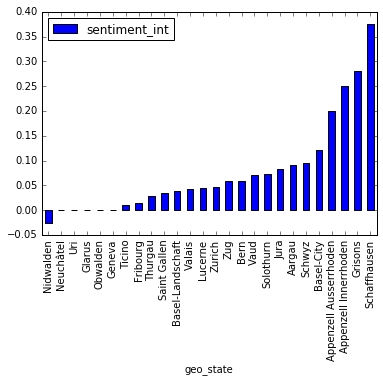

In [25]:
cff_sentiment.plot(kind="bar")

In [26]:
all_sentiment = main_df.groupby("geo_state").mean()
append_state_code(all_sentiment)
all_sentiment.sort_values(by="sentiment_int")

,sentiment_int,state_code
geo_state,,
Ticino,0.021628,TI
Neuchâtel,0.050457,NE
Jura,0.053901,JU
Zug,0.054100,ZG
Nidwalden,0.054857,NW
Geneva,0.061216,GE
Schaffhausen,0.066330,SH
Valais,0.070765,VS
Glarus,0.075901,GL


In [27]:
geo_path = 'utils/ch-cantons.topojson.json'
    

all_map = folium.Map(location=[46.57, 8], zoom_start=8)
all_map.choropleth(geo_path=geo_path, 
                     data=all_sentiment,
                     columns=['state_code', 'sentiment_int'],
                     key_on='feature.id',
                     topojson='objects.cantons',
                     fill_color='YlGn'
                    )
all_map

C:\Users\bls73\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


In [28]:
all_sentiment_en = main_df[main_df["lang"] == 'en'].groupby("geo_state").mean()
append_state_code(all_sentiment_en)
all_sentiment_en.sort_values(by="sentiment_int")

,sentiment_int,state_code
geo_state,,
Nidwalden,0.057000,NW
Zug,0.070437,ZG
Glarus,0.082623,GL
Jura,0.111704,JU
Geneva,0.128272,GE
Ticino,0.130595,TI
Basel-Landschaft,0.144489,BL
Basel-City,0.148550,BS
Aargau,0.156174,AG


In [29]:
geo_path = 'utils/ch-cantons.topojson.json'
    

all_en_map = folium.Map(location=[46.57, 8], zoom_start=8)
all_en_map.choropleth(geo_path=geo_path, 
                     data=all_sentiment_en,
                     columns=['state_code', 'sentiment_int'],
                     key_on='feature.id',
                     topojson='objects.cantons',
                     fill_color='YlGn'
                    )
all_en_map

C:\Users\bls73\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


**We think that the sentiment analysis works best on english, and gives lots of "NEUTRAL" values with other languages. It's then better to use only english (~45% of the tweets)**

In [30]:
def search_df(df, search_terms, search_exclusive=False, langs=[]):
    # Lowercase search terms
    search_terms = [t.lower() for t in search_terms]
    
    if len(langs) > 0:
        lang_filtered = df[df['lang'].isin(langs)]
    else:
        lang_filtered = df
    
    # Create a boolean array to subset the dataframe with search matching terms
    if search_exclusive:
        search_filter_bool = np.ones(len(lang_filtered), dtype=bool)
        
        for term in search_terms:
            search_filter_bool = search_filter_bool & lang_filtered['main'].str.lower().str.contains(term)
    else:
        search_filter_bool = np.zeros(len(lang_filtered), dtype=bool)

        for term in search_terms:
            search_filter_bool = search_filter_bool | lang_filtered['main'].str.lower().str.contains(term)
    
    return lang_filtered[search_filter_bool]

In [31]:
search_df(main_df, search_terms=['sbb', 'cff', 'ffs']).sample(5)['main']

2488     The place with the best music at Sundays. (@ P...
674      @mvp_zrh esch au chli naiv gsi, de Tag vor em ...
13493    Wer ist am Innovativsten: @uber_schweiz vs @co...
38433    Good #Liftoffs are so vital. Groups are so use...
48847    @Herr_Natischer Wären die Stürmer in gelb-schw...
Name: main, dtype: object

In [32]:
search_df(main_df, search_terms=['paleo', 'festival'], langs=['en'], search_exclusive=True)

,author_gender,geo_country,geo_state,lang,main,published,sentiment,source_location,sentiment_int
16780,UNKNOWN,CH,Vaud,en,#CarlosNuñez at @paleofestival http://www.sigf...,2016-08-01T08:53:19Z,NEUTRAL,Nyon,0.0
22280,UNKNOWN,CH,Vaud,en,@louiseattaqueofficiel at @paleofestival http:...,2016-08-01T12:23:37Z,NEUTRAL,Nyon,0.0
24740,UNKNOWN,CH,Geneva,en,Look back at Paleo 2016 now on http://currentl...,2016-08-01T09:36:41Z,NEUTRAL,"Geneva, Switzerland",0.0
29382,UNKNOWN,CH,Geneva,en,Look back at Paleo now on http://currentlywear...,2016-08-01T09:53:11Z,NEUTRAL,"Geneva, Switzerland",0.0
18195,UNKNOWN,CH,Vaud,en,@thetwo_blues at @paleofestival http://www.sig...,2016-08-02T17:47:19Z,NEUTRAL,Nyon,0.0
19191,UNKNOWN,CH,Vaud,en,@leroisangus at @paleofestival http://www.sigf...,2016-08-02T13:59:56Z,NEUTRAL,Nyon,0.0
23842,UNKNOWN,CH,Vaud,en,Tiken Jah Fakoly at @paleofestival http://www....,2016-08-02T11:11:31Z,NEUTRAL,Nyon,0.0
20817,UNKNOWN,CH,Vaud,en,@bastilledan at @paleofestival http://www.sigf...,2016-08-03T19:42:42Z,NEUTRAL,Nyon,0.0
25249,UNKNOWN,CH,Vaud,en,@giedrelalala at @paleofestival http://www.sig...,2016-08-03T06:24:19Z,NEUTRAL,Nyon,0.0
28669,UNKNOWN,CH,Vaud,en,#ClubMatin opening the hostilities at our #Pal...,2016-08-03T07:51:41Z,NEUTRAL,Geneva / Berlin,0.0


In [33]:
main_df.groupby("lang").count().sort_values(by="main", ascending=False)["main"].head(10)

lang
en    1685861
de     738792
fr     735342
es     373557
it     118669
sv      16112
da       7717
no       4945
fi       4229
el       3473
Name: main, dtype: int64

**main languages are English (en), German (de), French (fr), Spanish (es) and Italian (it)**

**Seems like there is more spanish than italian... Might be a problem with the language detection**

In [34]:
main_df[main_df['lang'] == 'es'].groupby('geo_state').count().sort_values('main', ascending=False)['main']

geo_state
Ticino                    201674
Geneva                     64756
Zurich                     26542
Valais                     18884
Vaud                       10888
Bern                       10291
Aargau                      8178
Basel-City                  7914
Uri                         4653
Zug                         3410
Saint Gallen                3142
Lucerne                     2760
Jura                        1664
Neuchâtel                   1505
Nidwalden                   1497
Grisons                     1069
Fribourg                     956
Thurgau                      929
Basel-Landschaft             666
Schaffhausen                 659
Schwyz                       507
Appenzell Innerrhoden        305
Solothurn                    300
Glarus                       208
Obwalden                     182
Appenzell Ausserrhoden        18
Name: main, dtype: int64

In [35]:
main_df[main_df['lang'] == 'it'].groupby('geo_state').count().sort_values('main', ascending=False)['main']

geo_state
Ticino                    62672
Zurich                    15545
Geneva                    15232
Basel-City                 5489
Vaud                       4247
Bern                       3196
Neuchâtel                  2714
Saint Gallen               1458
Aargau                     1404
Grisons                    1274
Valais                     1089
Solothurn                   961
Appenzell Innerrhoden       751
Zug                         588
Fribourg                    482
Lucerne                     366
Jura                        296
Uri                         256
Basel-Landschaft            173
Thurgau                     119
Schaffhausen                113
Nidwalden                    85
Appenzell Ausserrhoden       67
Schwyz                       42
Obwalden                     38
Glarus                       12
Name: main, dtype: int64

In [36]:
main_df[main_df['lang'] == 'pt'].groupby('geo_state').count().sort_values('main', ascending=False)['main']

geo_state
Geneva                   849
Basel-City               285
Vaud                     283
Zurich                   236
Valais                   178
Aargau                   124
Jura                     108
Bern                      87
Ticino                    65
Schaffhausen              57
Fribourg                  45
Neuchâtel                 30
Zug                       28
Lucerne                   25
Obwalden                  18
Saint Gallen              16
Basel-Landschaft           9
Appenzell Innerrhoden      7
Grisons                    6
Schwyz                     6
Uri                        5
Nidwalden                  4
Thurgau                    2
Solothurn                  1
Name: main, dtype: int64

In [37]:
def append_date(df):
    return df["published"].apply(parse_date)

In [38]:
main_df.sample()["published"].to_string(index=False)

'2016-08-22T18:07:17Z'

In [39]:
def parse_date(string):
    datetime_fmt = "%Y-%m-%dT%H:%M:%SZ"
    
    return datetime.strptime(string, datetime_fmt)

In [40]:
main_df.sample(10)["published"].apply(parse_date)

12830   2016-08-09 05:00:54
8378    2016-07-15 20:04:56
7797    2016-10-19 01:26:51
3676    2016-10-31 13:39:46
6873    2016-09-03 20:46:17
42836   2016-09-19 15:00:30
30493   2016-07-18 14:35:06
54160   2016-10-26 10:49:43
41325   2016-10-26 06:04:34
62285   2016-10-26 14:18:03
Name: published, dtype: datetime64[ns]

In [41]:
main_df["published"] = main_df["published"].apply(parse_date)

In [42]:
#with open("datasets/parsed_filtered_df.pkl", "wb") as handle:
#    pickle.dump(main_df, handle)

In [51]:
for _, state in main_df.items():
    print(state) 


63        FEMALE
64       UNKNOWN
65          MALE
66       UNKNOWN
68        FEMALE
69        FEMALE
71        FEMALE
72        FEMALE
73          MALE
74       UNKNOWN
77          MALE
79       UNKNOWN
81          MALE
85          MALE
86        FEMALE
87          MALE
88          MALE
89        FEMALE
90          MALE
91       UNKNOWN
92          MALE
95       UNKNOWN
96          MALE
97        FEMALE
100      UNKNOWN
101      UNKNOWN
104      UNKNOWN
105      UNKNOWN
106      UNKNOWN
107         MALE
          ...   
58569    UNKNOWN
58570       MALE
58572    UNKNOWN
58574    UNKNOWN
58575    UNKNOWN
58576    UNKNOWN
58577    UNKNOWN
58579    UNKNOWN
58580     FEMALE
58581       MALE
58582    UNKNOWN
58583    UNKNOWN
58584    UNKNOWN
58586    UNKNOWN
58589       MALE
58590    UNKNOWN
58592     FEMALE
58593    UNKNOWN
58594    UNKNOWN
58595       MALE
58596       MALE
58597    UNKNOWN
58598    UNKNOWN
58599       MALE
58600    UNKNOWN
58601    UNKNOWN
58603       MALE
58604    UNKNO

In [62]:
np.arange(-1,1.1, 0.25)

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ])